In [32]:
Langzeitmodus
import pandas as pd
from os.path import join

# Ergebnisordner des Langzeitmoduls
_path = r"C:\Users\devin.feng\Desktop\Git\mobitopp-rastatt\output\rastatt\demand-data"
### Analyse der Haushalte
_HH = pd.read_csv(join(_path, "household.csv"), sep=";")
# Haushalts-Attribute
household_attributes = list(_HH.columns)
df = pd.DataFrame(household_attributes)

# Anzahl Haushalte
num_of_HH = len(_HH)
# Haushalte pro Zelle
HH_per_zone = _HH.homeZone.value_counts()
# Anzahl der Pkw pro Haushalt
cars_per_household = _HH.totalNumberOfCars.value_counts()
print(household_attributes)

### Analyse der Personen
_persons = pd.read_csv(join(_path, "person.csv"), sep=";")
# Personen-Attribute
person_attributes = list(_persons.columns)
# Anzahl Personen
num_of_persons = len(_persons)
# Alter
mean_age = _persons.age.mean()
# Geschlecht
gender_distr = _persons.gender.value_counts(normalize=True)
# Beschäftigung
employment_distr = _persons.employment.value_counts()
#Anzahl Personen pro Haushalt
household_size_distr = _persons.groupby("householdId").size().value_counts()
### Auswertung Mobilitaetswerkzeuge
# OeV-Zeitkarte
ticket_distr = _persons.hasCommuterTicket.value_counts()
# Fuehrerschein
license_distr = _persons.hasLicense.value_counts()

from pandas import merge
### Verschneiden der Personen- und Haushaltstabelle
### (für manche Fragestellungen erforderlich)
_merged = pd.merge(_persons, _HH, on="householdId")
_age = _merged.age #Abkürzung für das 'age' attribut
# Verteilung der Minderjaehrigen bzw. Volljaehrigen
# in die Verkehrszellen
persons_per_zone = _merged.homeZone.value_counts()
minors_per_zone = _merged[_age < 18].homeZone.value_counts()
adults_per_zone = _merged[_age >= 18].homeZone.value_counts()


['householdId', 'year', 'householdNumber', 'nominalSize', 'domCode', 'type', 'homeZone', 'homeLocation', 'homeX', 'homeY', 'numberOfMinors', 'numberOfNotSimulatedChildren', 'totalNumberOfCars', 'income', 'incomeClass', 'economicalStatus', 'canChargePrivately']


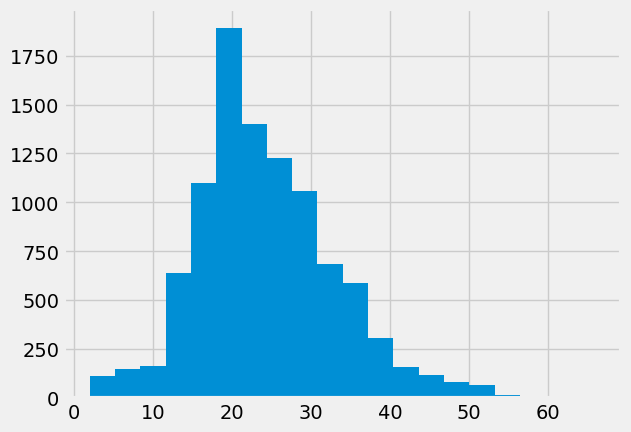

In [34]:
# HHs in short term model

import pandas as pd
from os.path import join
import matplotlib

(matplotlib.style.use('fivethirtyeight'))

_path = r"C:\Users\devin.feng\Desktop\Git\mobitopp-rastatt\output"
_short_term_path = join(_path, 'rastatt/results/simulation')
_long_term_path = join(_path, 'rastatt/demand-data')
### Einstieg (Uebersicht ueber die Daten gewinnen) ###
_trip_file = join(_short_term_path, 'demandsimulationResult.csv')
_trips = pd.read_csv(_trip_file, sep=";")
# Attribute und Kopf der Trip-Tabelle
trip_attributes = _trips.columns
trips_head = _trips.head()
# Anzahl aller Wege
num_of_trips = len(_trips)
# Verteilung der Wege auf die Personen
_trips_per_person = _trips.groupby('personOid').size()
_trips_per_person.hist(bins=20) #Histogramm-Plot
num_of_trips_distr = _trips_per_person.value_counts()
